# Homework 3 

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

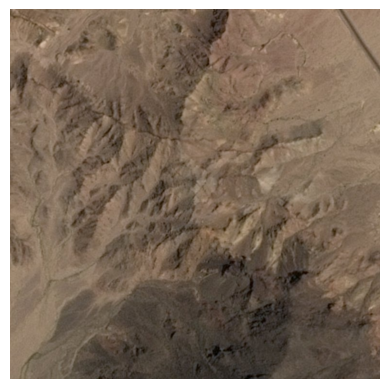

155993.0
376095.0
Desert


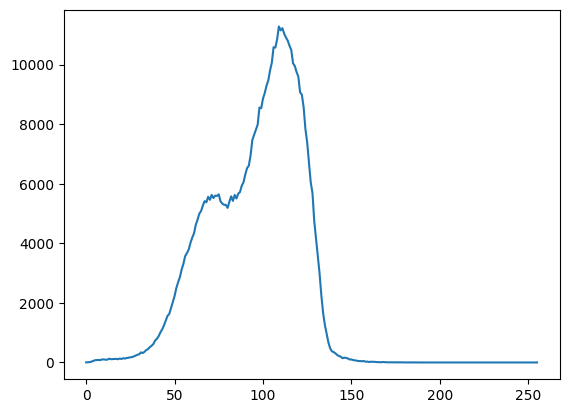

In [24]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_compute_histogram(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')  
    plt.show()

    image_to_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist_image = cv2.calcHist([image_to_gray.ravel()], [0], None, [256], [0, 256])
    plt.plot(hist_image)

    return hist_image.flatten()

def determine_land_type(image_path):
    hist = load_and_compute_histogram(image_path)
    green_index = np.sum(hist[20:80])  
    yellow_index = np.sum(hist[90:200])  
    
    if green_index > yellow_index:
        return 'Forest'
    else:
        return 'Desert'


img_path = 'desert_forest/test_image_04.jpg'

print(determine_land_type(img_path))

# Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

Статья, где описан метод  

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. https://doi.org/10.1145/882262.882269

Пример такого совмещения:

<img src="../homework/blending/blending.png" alt="Drawing" style="width: 700px;"/>


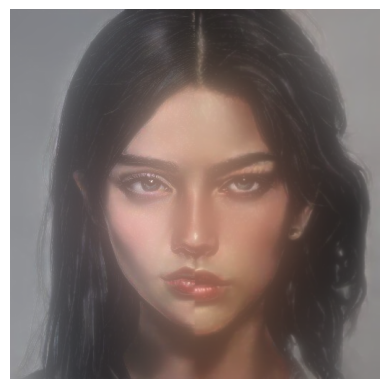

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def blend_images_using_pyramids(image1, image2, levels=6):

    G1 = image1.copy()
    gp1 = [G1]
    for i in range(levels):
        G1 = cv2.pyrDown(G1)
        gp1.append(G1)


    G2 = image2.copy()
    gp2 = [G2]
    for i in range(levels):
        G2 = cv2.pyrDown(G2)
        gp2.append(G2)


    lp1 = [gp1[levels]]
    for i in range(levels, 0, -1):
        GE = cv2.pyrUp(gp1[i])
        L = cv2.subtract(gp1[i-1], GE)
        lp1.append(L)


    lp2 = [gp2[levels]]
    for i in range(levels, 0, -1):
        GE = cv2.pyrUp(gp2[i])
        L = cv2.subtract(gp2[i-1], GE)
        lp2.append(L)

 
    LS = []
    for l1, l2 in zip(lp1, lp2):
        rows, cols, dpt = l1.shape
        ls = np.hstack((l1[:, 0:cols//2], l2[:, cols//2:]))
        LS.append(ls)

    ls_ = LS[0]
    for i in range(1, levels+1):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, LS[i])

    return ls_


source_img_1 = cv2.imread('blending/7b4aed4d8748d7be28fadeeaf76cd27e.jpg')
source_img_2 = cv2.imread('blending/Mercedes_Wood_-_1.webp')

source_img_1 = cv2.resize(source_img_1, (512, 512))
source_img_2 = cv2.resize(source_img_2, (512, 512))


result = blend_images_using_pyramids(source_img_1, source_img_2)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# в целом неплохо


# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

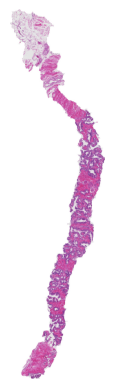

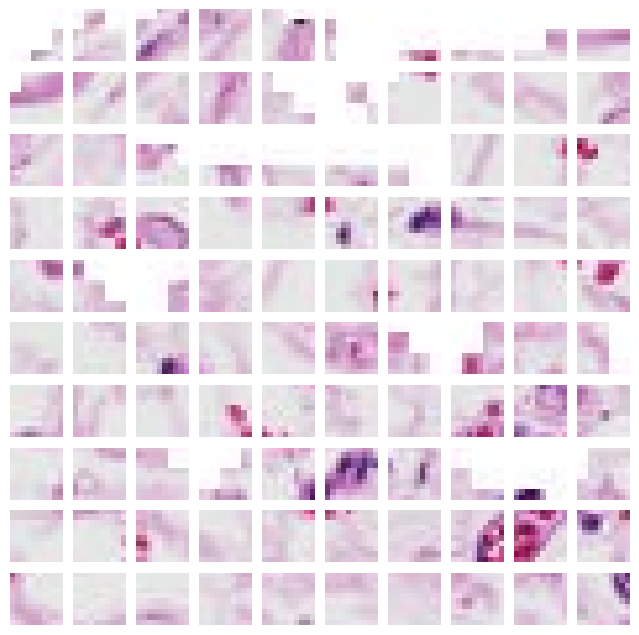

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Функция для выделения ячеек из изображения
def extract_cells(image_path, cell_size, num_cells):
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    

    num_cells_x = min(num_cells, image_width // cell_size)
    num_cells_y = min(num_cells, image_height // cell_size)
    
    cells = []
    
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            # Вычисляем координаты ячейки
            x_start = j * cell_size
            y_start = i * cell_size
            x_end = x_start + cell_size
            y_end = y_start + cell_size
            
            # Вырезаем ячейку из изображения
            cell = image[y_start:y_end, x_start:x_end]
            if np.sum(np.any(cell < 200, axis=-1)) > 5:

                cells.append(cell)
            if num_cells <= len(cells):
                break
        if num_cells <= len(cells):
            break
    return cells

def display_cells(cells):
    num_cells = len(cells)
    plt.figure(figsize=(8,8))
    
    for i, cell in enumerate(cells):
        plt.subplot(int(np.sqrt(num_cells)), int(np.sqrt(num_cells)), i + 1)
        plt.imshow(cv2.cvtColor(cell, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    
    plt.show()

path_to_img = 'cells/train3_1.jpeg'
image = cv2.imread(path_to_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')  
plt.show()

cells = extract_cells(path_to_img, cell_size=10, num_cells=100)
display_cells(cells)

In [46]:
image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]